# Evaluation of the Image Segmentation results
This Notebook is seperated from the actual Pipeline and has the purpose to measure the exact performance of the Image Segmentation pipeline part


**Prequesits to run this notebook**

Download the Standford Background Dataset https://www.kaggle.com/datasets/tapakah68/segmentation-full-body-mads-dataset and extract it to ``data/input/human-segmentation``

In [1]:
# Replace Paths with your local ones if requred

input_image_path = "../data/input/human-segmentation/images/"
working_depth_path = "../data/working/human-segmentation-depth/"

output_no_depth_path = "C:/dev/TU/htcv-project/evals-for-doc/segmentation/human-segmentation-mask-no-depth/pred/"
output_with_depth_path = "C:/dev/TU/htcv-project/evals-for-doc/segmentation/human-segmentation-mask-with-depth/pred/" 

output_iou_no_depth_path = "C:/dev/TU/htcv-project/evals-for-doc/segmentation/human-segmentation-mask-no-depth/iou/"
output_iou_with_depth_path = "C:/dev/TU/htcv-project/evals-for-doc/segmentation/human-segmentation-mask-with-depth/iou/" 

ground_truth_path = "../data/input/human-segmentation/masks"

### Step 1: Run the Image Segmentation complete pipeline AND without the depth estimation

In [8]:
from pipeline_util.context import PipeContext
from pipeline_util.pipeline import *
from pipeline_steps.ImageBinarizerRMBG import ImageBinarizerRMBG
from pipeline_steps.ImageBinarizerRMBGNoDepth import ImageBinarizerRMBGNoDepth
from pipeline_steps.DepthEstimator import DepthEstimator


# Empty context to be able to start the pipeline
def get_new_context():
    return PipeContext(
        input_dir_path="data/input", output_dir_path="data/output",
        working_dir_path="data/working", misc_dir_path="",
        log_file_path="", current_run_export_dir=""
    )

def error_handler(error: Exception, context: Context, next_step: NextStep):
    print(error)
    raise ValueError(error) from error

def run_image_segmentation_pipeline_no_depth(input_path, output_path):
    ctx = get_new_context()
    pipeline_pie = Pipeline[PipeContext](
        ImageBinarizerRMBGNoDepth(input_path, output_path, target_width=-1, limit=300),
    )
    pipeline_pie(ctx, error_handler)
    
def run_image_segmentation_pipeline_with_depth(input_path, depth_working_path, output_path):
    ctx = get_new_context()
    pipeline_pie = Pipeline[PipeContext](
        DepthEstimator(input_path, depth_working_path, threshold=110, limit=300),
        ImageBinarizerRMBG(input_path, depth_working_path, output_path, limit=300),
    )
    pipeline_pie(ctx, error_handler)


In [9]:
run_image_segmentation_pipeline_no_depth(input_image_path, output_no_depth_path)
run_image_segmentation_pipeline_with_depth(input_image_path, working_depth_path, output_with_depth_path)

Pipeline Progress: 1 steps left


C:\Users\alex\anaconda3\envs\nerfstudio\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


saved image mask: C:/dev/TU/htcv-project/evals-for-doc/segmentation/human-segmentation-mask-no-depth/pred/HipHop_HipHop1_C0_00180.png
saved image mask: C:/dev/TU/htcv-project/evals-for-doc/segmentation/human-segmentation-mask-no-depth/pred/HipHop_HipHop1_C0_00225.png
saved image mask: C:/dev/TU/htcv-project/evals-for-doc/segmentation/human-segmentation-mask-no-depth/pred/HipHop_HipHop1_C0_00360.png
saved image mask: C:/dev/TU/htcv-project/evals-for-doc/segmentation/human-segmentation-mask-no-depth/pred/HipHop_HipHop1_C0_00405.png
saved image mask: C:/dev/TU/htcv-project/evals-for-doc/segmentation/human-segmentation-mask-no-depth/pred/HipHop_HipHop1_C0_00450.png
saved image mask: C:/dev/TU/htcv-project/evals-for-doc/segmentation/human-segmentation-mask-no-depth/pred/HipHop_HipHop1_C0_00540.png
saved image mask: C:/dev/TU/htcv-project/evals-for-doc/segmentation/human-segmentation-mask-no-depth/pred/HipHop_HipHop1_C0_00585.png
saved image mask: C:/dev/TU/htcv-project/evals-for-doc/segment

### Step 2: Evaluate the Exported Images by comparing with gorund truth

In [10]:
import os
import cv2
from sklearn.metrics import jaccard_score
import numpy as np

def compute_iou(image1, image2):
    # Flatten the images and compute the IoU
    image1_flat = image1.flatten()
    image2_flat = image2.flatten()
    iou = jaccard_score(image1_flat, image2_flat, average='micro')
    return iou

def create_overlay(image1, image2):
    # Create an RGB image for visualization
    overlay = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)

    # Intersection in green
    intersection = np.logical_and(image1, image2)
    overlay[intersection == 1] = [255, 255, 255]

    # Differences in red and blue
    only_image1 = np.logical_and(image1, np.logical_not(image2))
    only_image2 = np.logical_and(image2, np.logical_not(image1))

    overlay[only_image1 == 1] = [0, 0, 255]  # The predicted image
    overlay[only_image2 == 1] = [255, 0, 0]  # The ground truth image

    return overlay

def compare_folders(folder1, folder2, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    folder1_images = sorted(os.listdir(folder1))
    folder2_images = sorted(os.listdir(folder2))
    
    #in this case, cut the ground truth length to the input length
    folder1_images = folder1_images[0:len(folder2_images)]
    
    if len(folder1_images) != len(folder2_images):
        raise ValueError("The number of images in the two folders should be the same")

    total_iou = 0
    
    all_ious = []
    
    for img_name1, img_name2 in zip(folder1_images, folder2_images):
        img1_path = os.path.join(folder1, img_name1)
        img2_path = os.path.join(folder2, img_name2)

        img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)
        
        if img1.shape != img2.shape:
            raise ValueError(f"Image sizes do not match: {img_name1} and {img_name2}")

        iou = compute_iou(img1, img2)
        total_iou += iou

        overlay = create_overlay(img1, img2)
        overlay_path = os.path.join(output_folder, f"{img_name1}_overlay.png")
        cv2.imwrite(overlay_path, overlay)
        
        all_ious.append(iou)
        
    print("saved all IoU Images to " + output_folder)
    average_iou = total_iou / len(all_ious)

    with open(os.path.join(output_folder, 'average_iou.txt'), 'w') as f:
        f.write(f"Average IoU for all images: {average_iou:.4f}")

    print(f"Average IoU for all images: {average_iou:.4f}")
    
    return all_ious

In [11]:
# RUN
print("eval no depth: ")
ious_no_depth = compare_folders(ground_truth_path, output_no_depth_path, output_iou_no_depth_path)
print("-")
print("eval with depth: ")
ious_with_depth = compare_folders(ground_truth_path, output_with_depth_path, output_iou_with_depth_path)

eval no depth: 
saved all IoU Images to C:/dev/TU/htcv-project/evals-for-doc/segmentation/human-segmentation-mask-no-depth/iou/
Average IoU for all images: 0.9668
-
eval with depth: 
saved all IoU Images to C:/dev/TU/htcv-project/evals-for-doc/segmentation/human-segmentation-mask-with-depth/iou/
Average IoU for all images: 0.9677


### Result Evaluation / Visualization

In [12]:
import matplotlib.pyplot as plt

def plot_overlays(output_folder, title):
    # Get the list of overlay images in the output folder
    overlay_images = sorted([img for img in os.listdir(output_folder) if img.endswith('_overlay.png')])

    # Ensure there are at least 6 images to plot
    if len(overlay_images) < 4:
        raise ValueError('Not enough overlay images to plot. At least 6 required.')

    # Create a figure with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    fig.suptitle(title, fontsize=15)

    for i, ax in enumerate(axes.flat):
        # Read the image
        img_path = os.path.join(output_folder, overlay_images[i])
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

        # Display the image
        ax.imshow(img_rgb)
        ax.set_title(overlay_images[i])
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    
def scatter_both_models(pure_ious, osig_ious):
    # Create a box plot
    plt.figure(figsize=(6, 5))
    
    data = [pure_ious, osig_ious]
    
    plt.boxplot(data,
                labels=['L1 Pure', 'L1 oSig'],
                patch_artist=True, 
                boxprops=dict(facecolor='orange',
                    color='black',
                    alpha=0.5),
                whiskerprops=dict(color='black', alpha=1.0),
                medianprops=dict(color='black', alpha=0.0)) # dont show
    
    mean_pure = np.mean(pure_ious)
    mean_osig = np.mean(osig_ious)

    # Overlay individual data points
    for i, dataset in enumerate(data):
        plt.scatter([i + 1] * len(dataset), dataset, color='black', label='All IoUs' if i == 0 else "")
    
    #and mean
    plt.scatter([1], [mean_pure], color='green', edgecolor='black', s=100, zorder=5, label=f'Mean without depth: {mean_pure:.4f}')
    plt.scatter([2], [mean_osig], color='purple', edgecolor='black', s=100, zorder=5, label=f'Mean with depth: {mean_osig:.4f}')
    
    plt.xlim(0.5, 2.5) 
    
    plt.title('IoU Values of without depth and with depth')
    plt.xlabel('Class')
    plt.ylabel('Value')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles=handles, labels=labels, loc='best')

    
    # Render the plot
    plt.show()

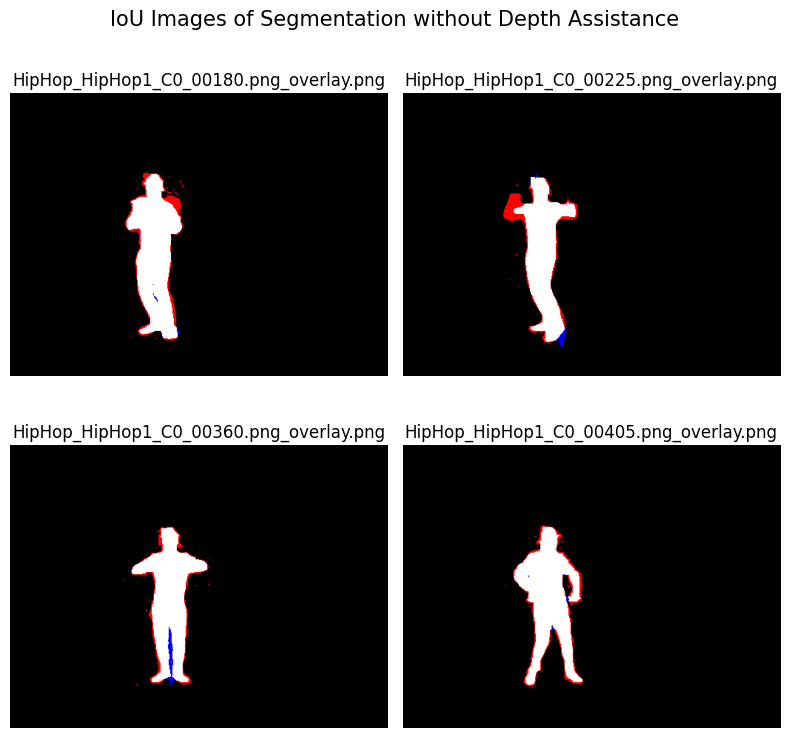

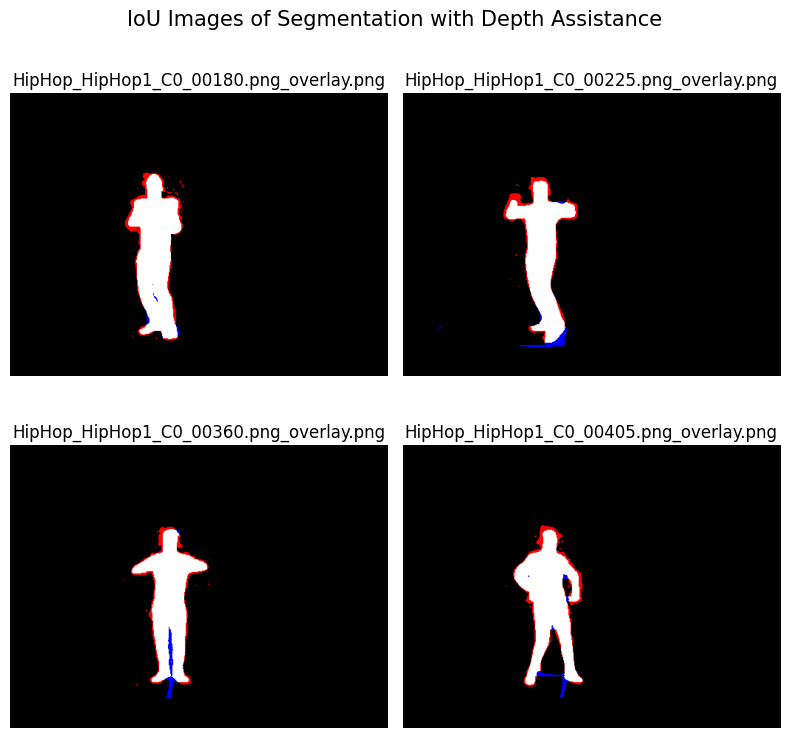

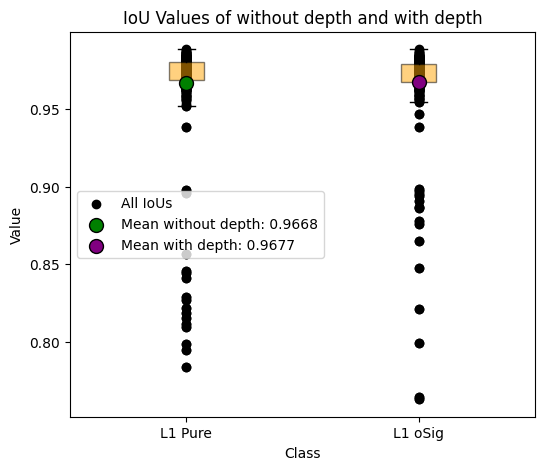

In [13]:
# Show IoU Images
plot_overlays(output_iou_no_depth_path, 'IoU Images of Segmentation without Depth Assistance')
plot_overlays(output_iou_with_depth_path, 'IoU Images of Segmentation with Depth Assistance')

# Show a Scatter Plot of all individual IoU values for no depth and with depth
scatter_both_models(ious_no_depth, ious_with_depth)